In [20]:
import pandas as pd
from datetime import datetime
import numpy as np
df = pd.read_csv('municipality_bus_utilization.csv', index_col=0)  


In [120]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [121]:
def func_usage(df, num_manp):
    df2 = df[df['municipality_id'] == num_manp]
    df2.index = pd.to_datetime(df2.index)
    df2["time"] = pd.to_datetime(df2.index)
    df3 = df2.resample('60min', offset=0, label='right')['usage'].max()
    df3 = df3.to_frame()
    df3 = df3.between_time('8:00', '17:00')
    for i in range(len(df3)):
        if(df3.index[i].hour==8 and pd.isna(df3['usage'][i])):
            df3.iloc[i]['usage'] = df3.iloc[i+1]['usage']

    df3['usage'] = df3['usage'].interpolate()
    
    return df3

---
#### First we do steps for municipality 0 and plot the results

In [122]:
import warnings
warnings.filterwarnings('ignore')

df2 = df[df['municipality_id'] == 0]
df2.index = pd.to_datetime(df2.index)
df2["time"] = pd.to_datetime(df2.index)
df2.rename({'usage': str(0)}, axis=1, inplace=True)


for i in range(1,10):
    new_col = df[df['municipality_id'] == i]['usage'].tolist()
    df2[str(i)] = new_col
    
df3 = df2[[str(i) for i in range(10)]]
df3 = df3.resample('60min', offset=0, label='right').max()
df3 = df3.between_time('8:00', '17:00')

for j in range(10):
    for i in range(len(df3)):
        if(df3.index[i].hour==8 and pd.isna(df3[str(j)][i])):
            df3.iloc[i][str(j)] = df3.iloc[i+1][str(j)]

    df3[str(j)] = df3[str(j)].interpolate()


df3['cnt'] = df3['0']
df3

,0,1,2,3,4,5,6,7,8,9,cnt
timestamp,,,,,,,,,,,
2017-06-04 08:00:00,204.0,129.0,273.0,623.0,1090.0,70.0,597.0,718.0,556.0,454.0,204.0
2017-06-04 09:00:00,332.0,164.0,355.0,967.0,2016.0,89.0,801.0,873.0,857.0,527.0,332.0
2017-06-04 10:00:00,485.0,245.0,494.0,1263.0,2811.0,159.0,1061.0,1151.0,1172.0,666.0,485.0
2017-06-04 11:00:00,583.0,317.0,582.0,1396.0,3178.0,228.0,1219.0,1373.0,1363.0,800.0,583.0
2017-06-04 12:00:00,614.0,341.0,643.0,1456.0,3257.0,268.0,1297.0,1479.0,1399.0,845.0,614.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-19 13:00:00,1281.0,406.0,663.0,1484.0,3157.0,258.0,1787.0,1503.0,1251.0,849.0,1281.0
2017-08-19 14:00:00,1283.0,408.0,697.0,1519.0,3194.0,300.0,1845.0,1627.0,1315.0,941.0,1283.0
2017-08-19 15:00:00,1285.0,410.0,687.0,1530.0,3183.0,318.0,1853.0,1657.0,1341.0,983.0,1285.0


In [140]:
train_size = len(df3)-140
test_size = 140
train, test = df3.iloc[0:train_size], df3.iloc[train_size:len(df3)]
print(len(train), len(test))

630 140


In [142]:
from sklearn.preprocessing import RobustScaler

f_columns = [str(i) for i in range(10)]

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)

test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

In [143]:
cnt_transformer = RobustScaler()

cnt_transformer = cnt_transformer.fit(train[['cnt']])

train['cnt'] = cnt_transformer.transform(train[['cnt']])

test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [144]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [145]:
time_steps = 10

# reshape to [samples, time_steps, n_features]
train['cnt'] 
test['cnt']

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(620, 10, 11) (620,)


In [146]:
import keras 
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [147]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
18/18 [==============================] - 5s 67ms/step - loss: 0.6310 - val_loss: 0.2530
Epoch 2/30
18/18 [==============================] - 0s 26ms/step - loss: 0.3543 - val_loss: 0.2904
Epoch 3/30
18/18 [==============================] - 0s 25ms/step - loss: 0.2696 - val_loss: 0.2687
Epoch 4/30
18/18 [==============================] - 0s 25ms/step - loss: 0.2374 - val_loss: 0.2826
Epoch 5/30
18/18 [==============================] - 0s 26ms/step - loss: 0.2045 - val_loss: 0.2706
Epoch 6/30
18/18 [==============================] - 0s 23ms/step - loss: 0.2071 - val_loss: 0.2558
Epoch 7/30
18/18 [==============================] - 0s 24ms/step - loss: 0.1910 - val_loss: 0.2949
Epoch 8/30
18/18 [==============================] - 0s 24ms/step - loss: 0.1749 - val_loss: 0.2252
Epoch 9/30
18/18 [==============================] - 0s 24ms/step - loss: 0.1551 - val_loss: 0.2637
Epoch 10/30
18/18 [==============================] - 0s 24ms/step - loss: 0.1431 - val_loss: 0.2445
Epoch 11/

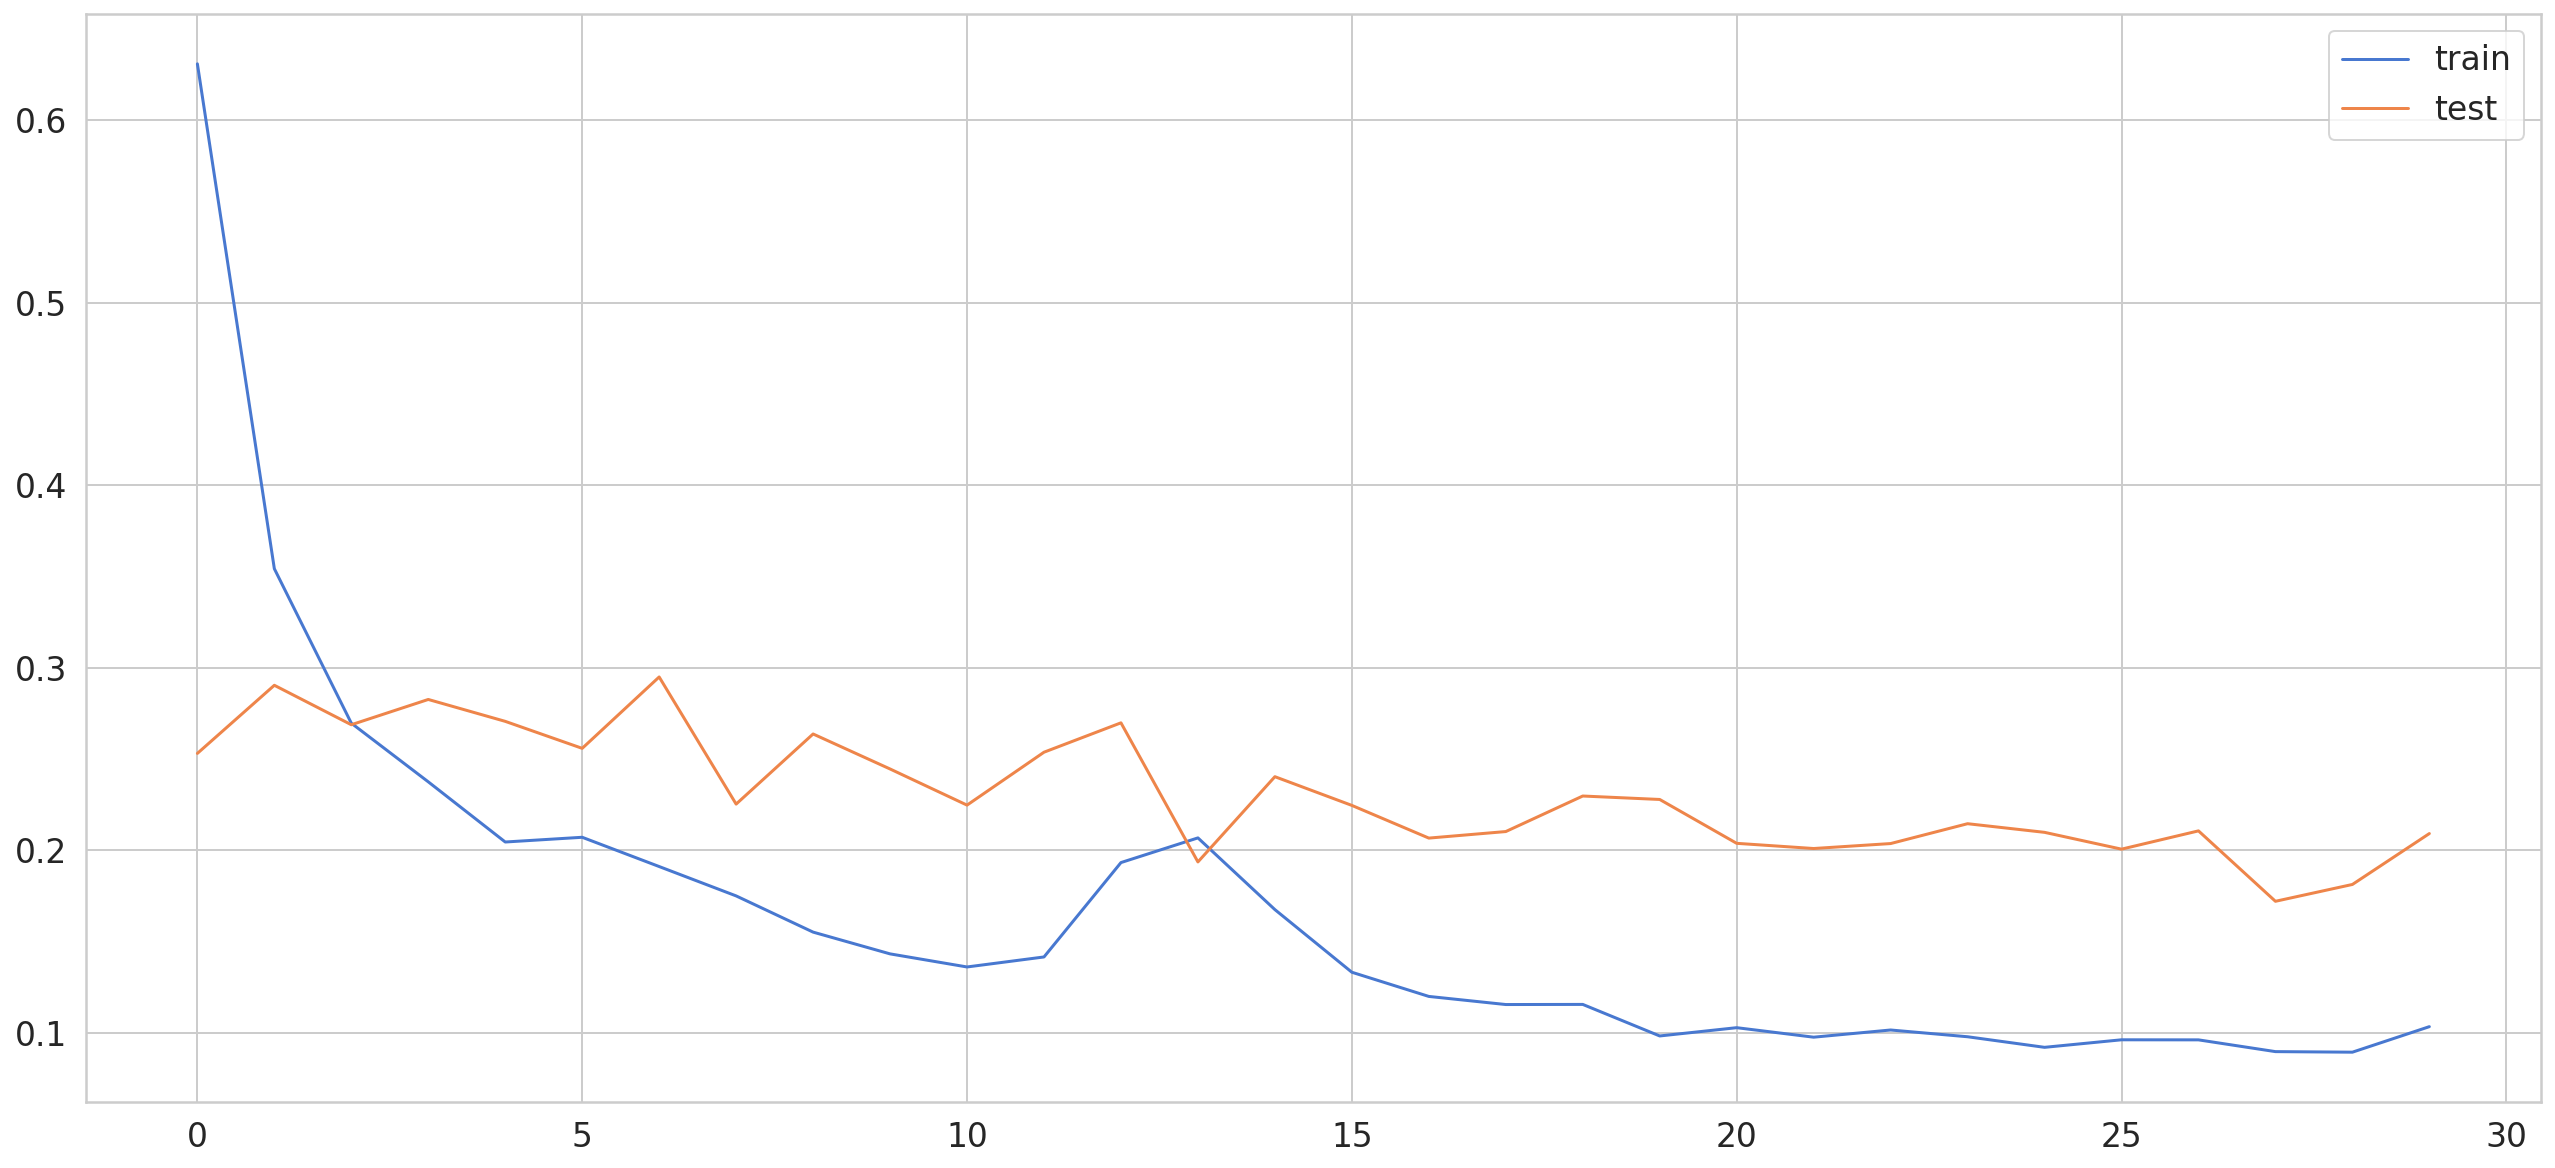

In [148]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [149]:
y_pred = model.predict(X_test)


In [150]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

#### Plots of previous data and our prediction

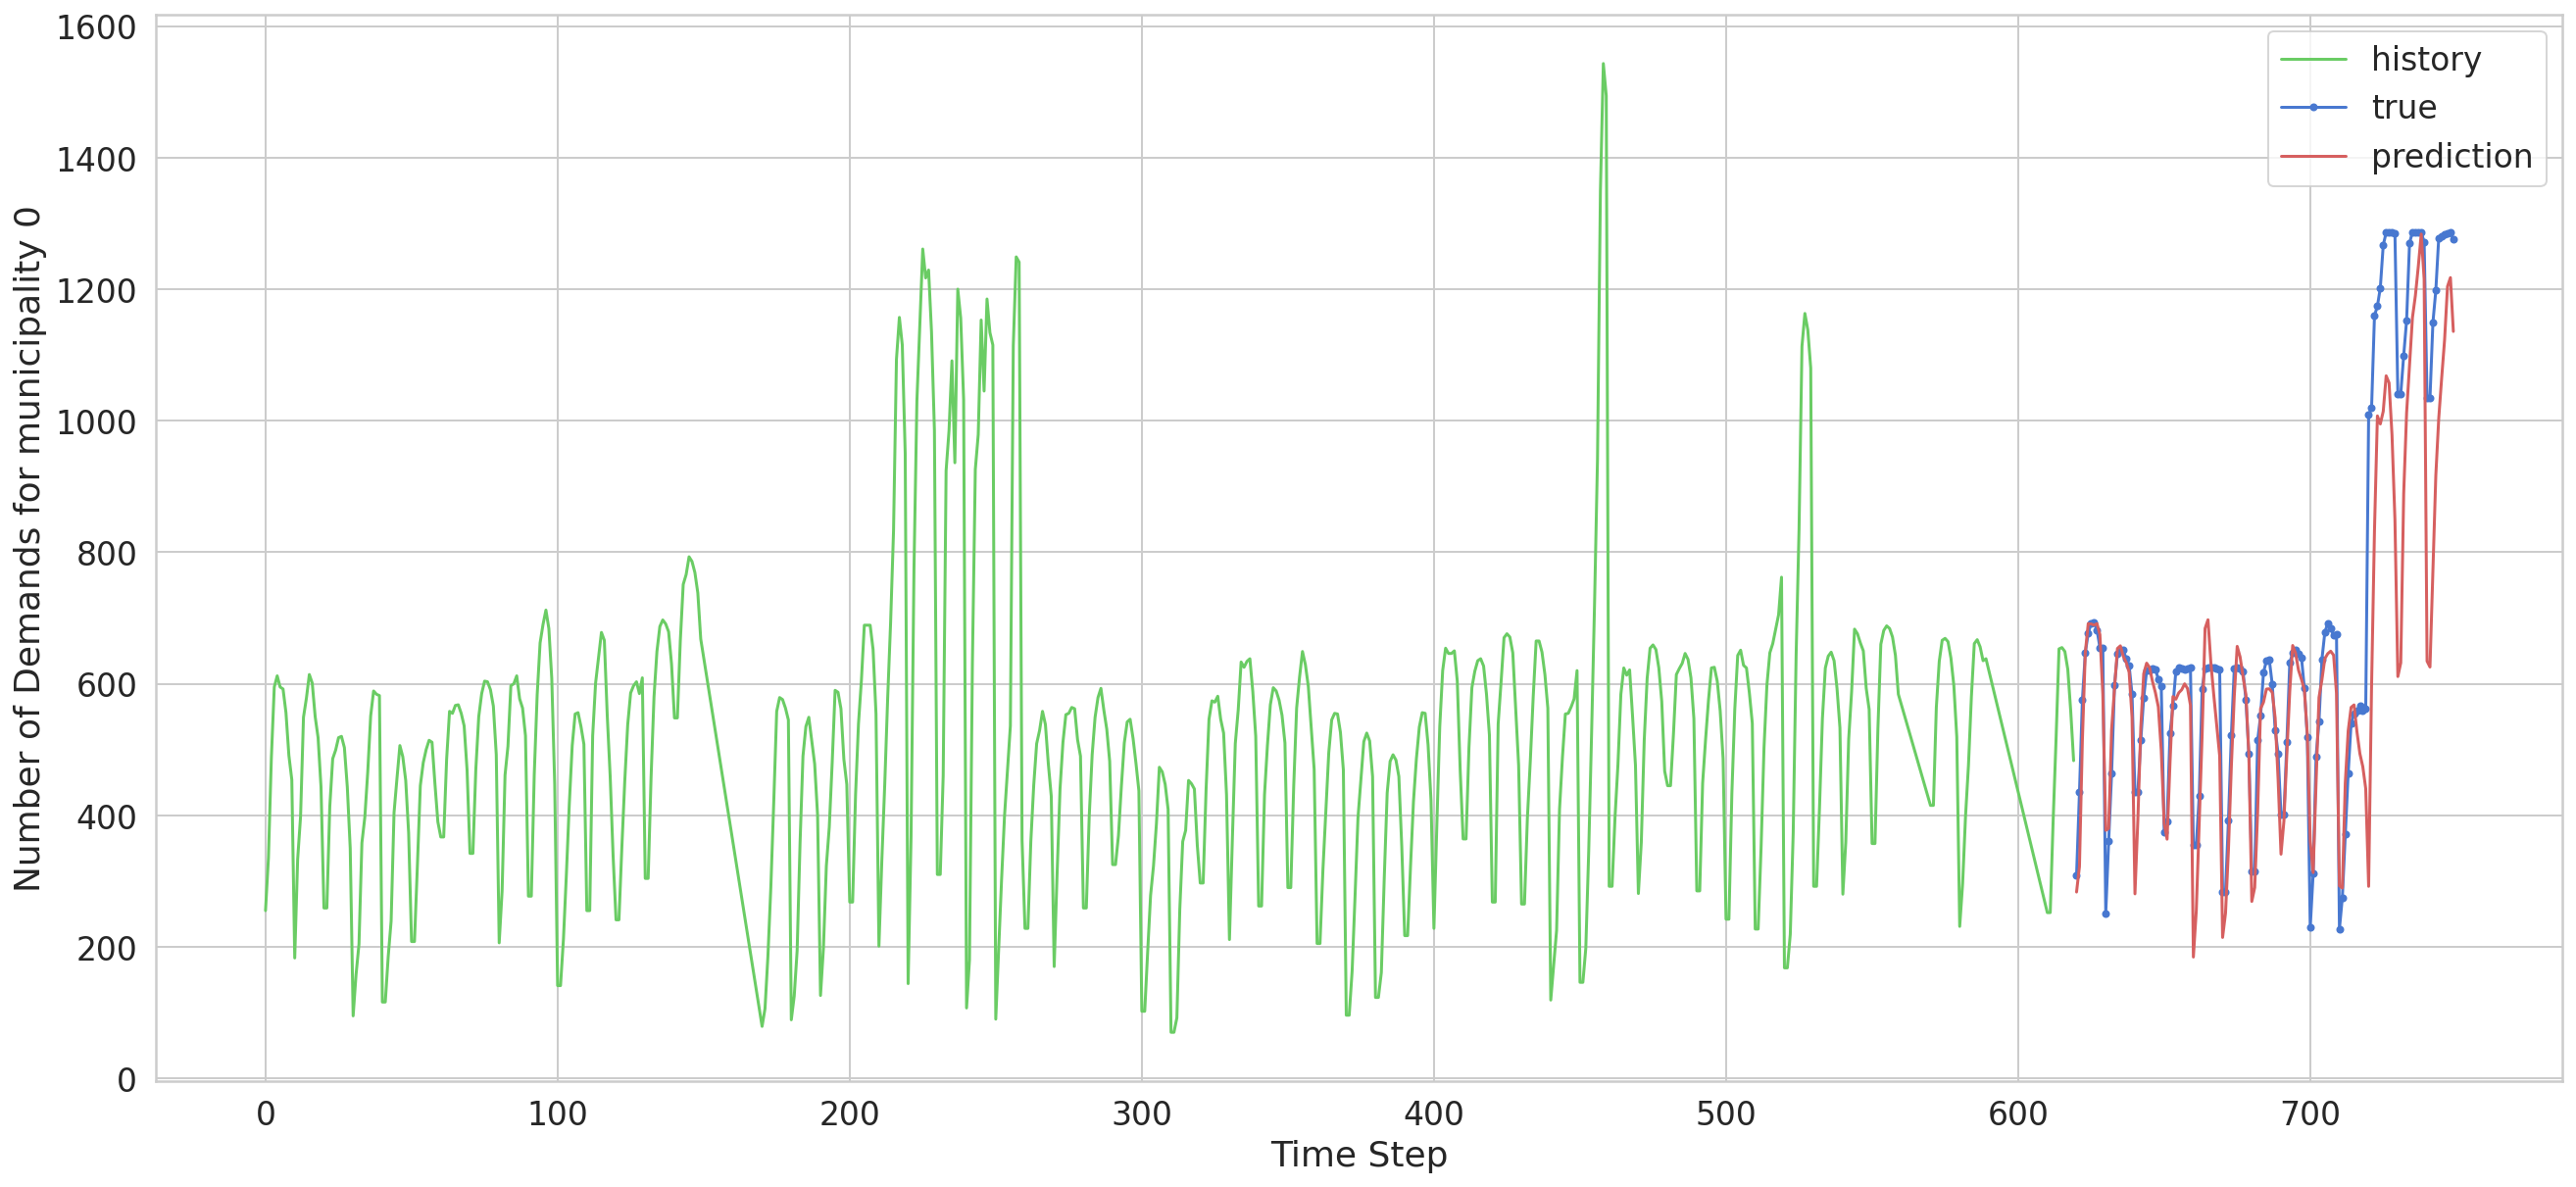

In [163]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Number of Demands for municipality 0')
plt.xlabel('Time Step')
plt.legend()
plt.show()

#### Plots of test part

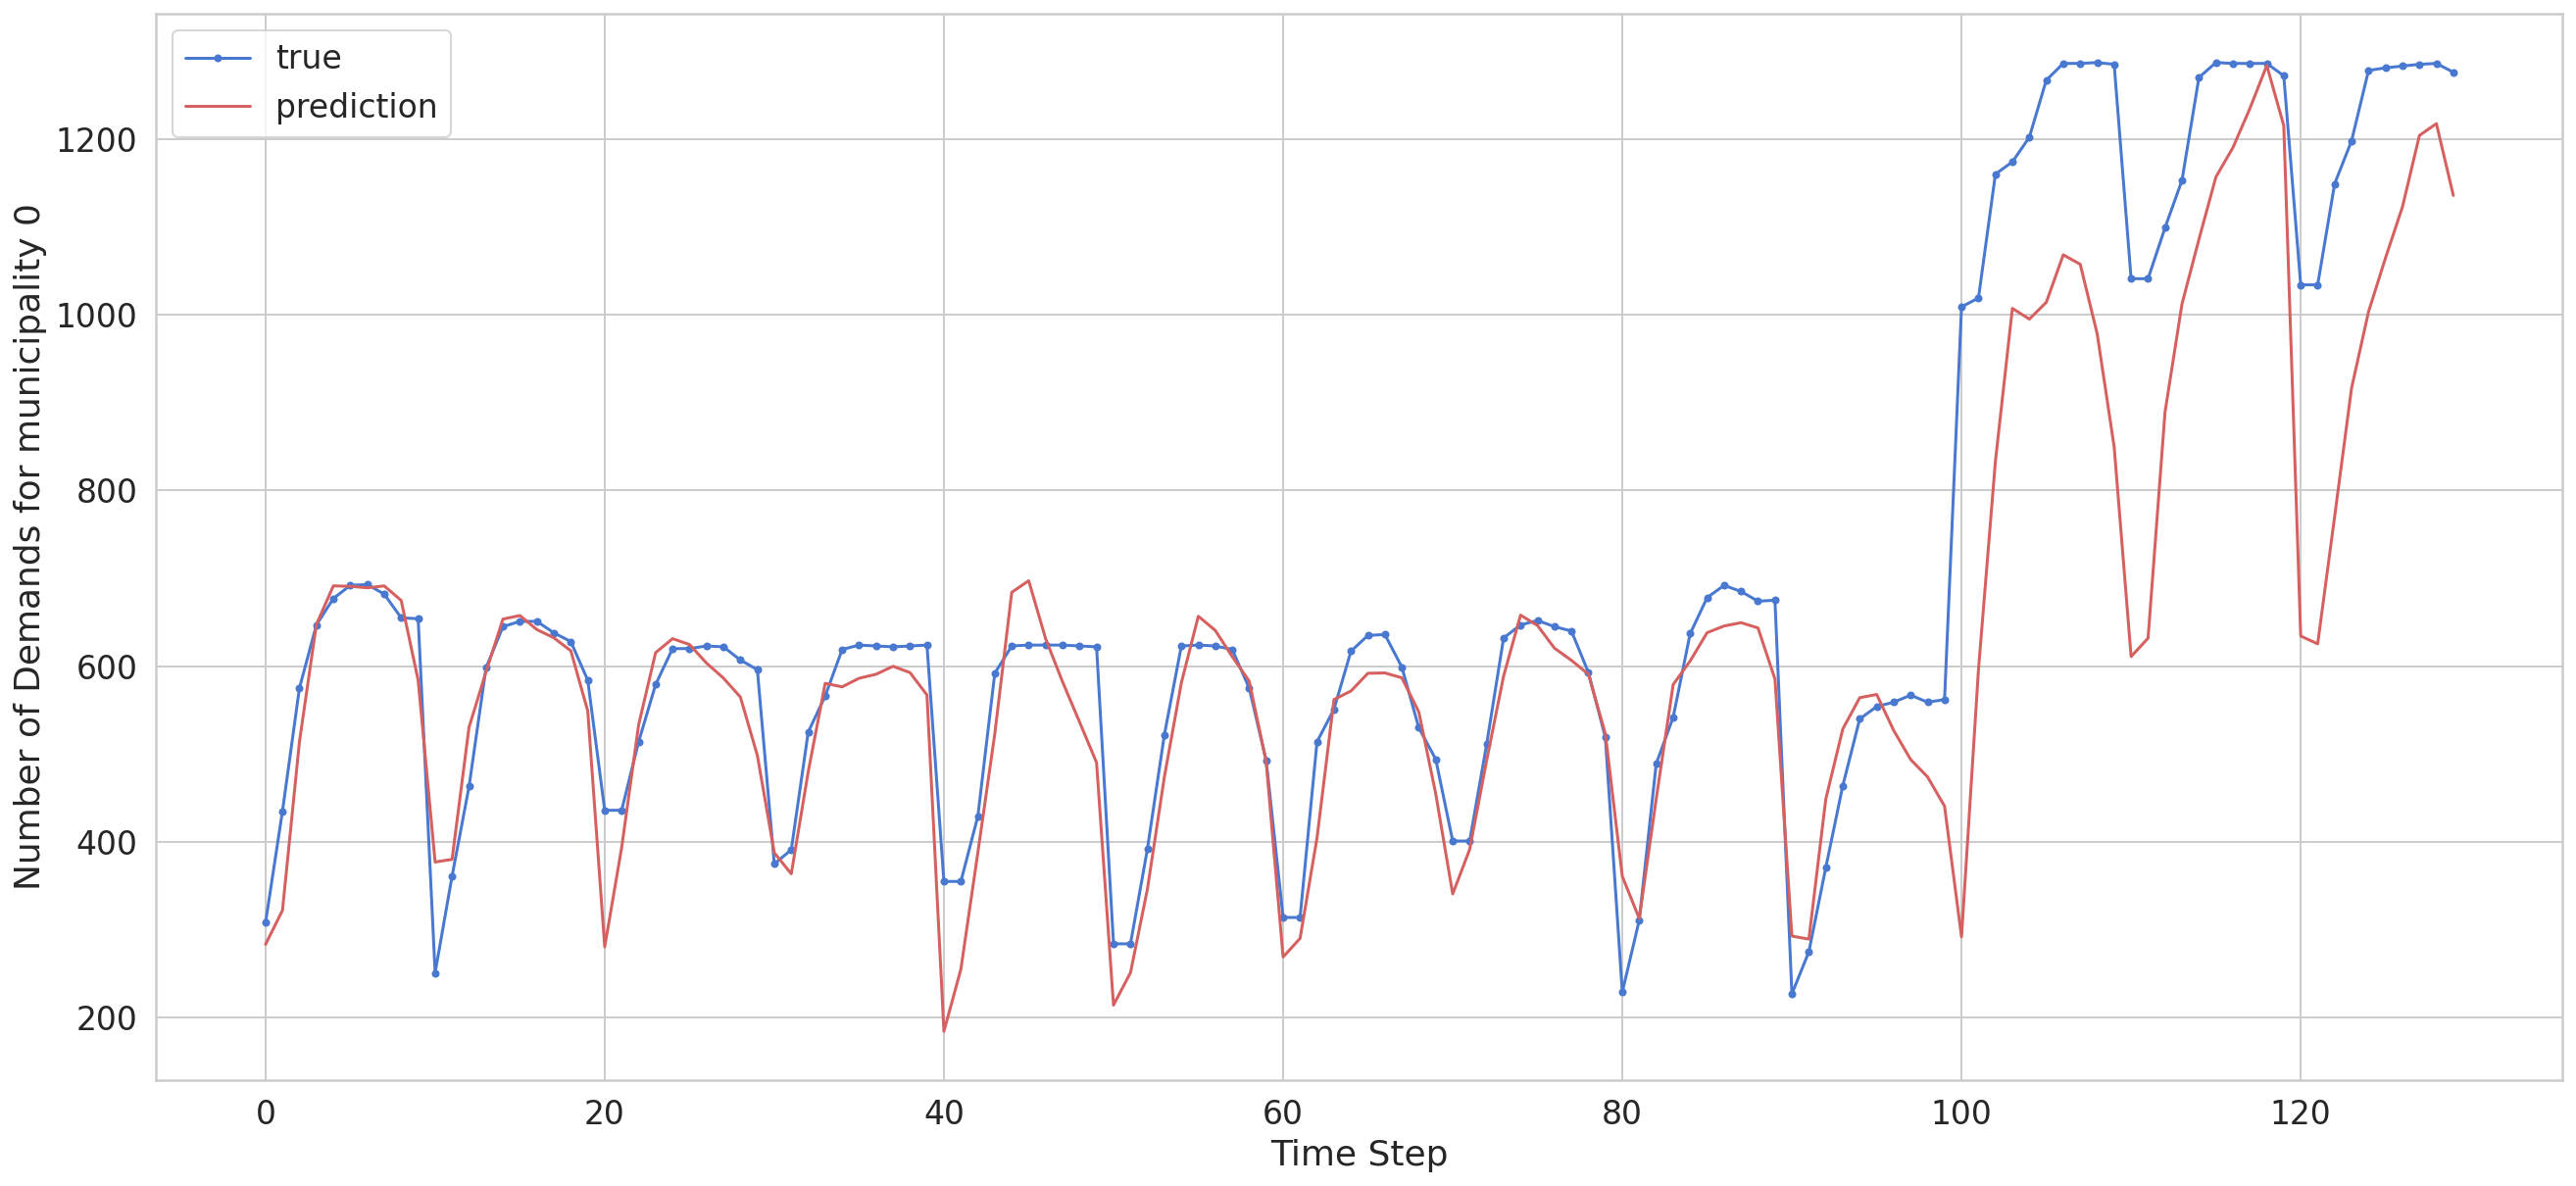

In [164]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Number of Demands for municipality 0')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [153]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test_inv[0][:70], y_pred_inv[:70]))
print('Test RMSE first week: %.3f' % rmse)

rmse = sqrt(mean_squared_error(y_test_inv[0][70:140], y_pred_inv[70:140]))
print('Test RMSE second week: %.3f' % rmse)

Test RMSE first week: 55.468
Test RMSE second week: 208.805


---
#### The below function is written to be used for all of municipalities

In [160]:
def train_predict(df3, num_manicip):
    global create_dataset
    global all_result
    print('manicip number {}'.format(num_manicip))
    df3['cnt'] = df3[str(num_manicip)]
    ##==============
    train_size = len(df3)-140
    test_size = 140
    train, test = df3.iloc[0:train_size], df3.iloc[train_size:len(df3)]
    ##==============
    f_columns = [str(i) for i in range(10)]
    f_transformer = RobustScaler()
    f_transformer = f_transformer.fit(train[f_columns].to_numpy())
    train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
    test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
    ##==============
    cnt_transformer = RobustScaler()
    cnt_transformer = cnt_transformer.fit(train[['cnt']])
    train['cnt'] = cnt_transformer.transform(train[['cnt']])
    test['cnt'] = cnt_transformer.transform(test[['cnt']])
    ##==============
    model = keras.Sequential()
    model.add(
      keras.layers.Bidirectional(
        keras.layers.LSTM(
          units=128,
          input_shape=(X_train.shape[1], X_train.shape[2])
        )
      )
    )
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    ##==============
    history = model.fit(
        X_train, y_train, 
        epochs=30, 
        batch_size=32, 
        validation_split=0.1,
        shuffle=False)
    ##==============
    y_pred = model.predict(X_test)
    ##==============
    y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
    y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
    y_pred_inv = cnt_transformer.inverse_transform(y_pred)
    
    rmse = sqrt(mean_squared_error(y_test_inv[0][:70], y_pred_inv[:70]))
    print('Test RMSE first week for manicip {} is : {}'.format(num_manicip,rmse))
    all_result[num_manicip]['First weeek'] = rmse

    rmse = sqrt(mean_squared_error(y_test_inv[0][70:140], y_pred_inv[70:140]))
    print('Test RMSE second week for manicip {} is : {}'.format(num_manicip,rmse))
    all_result[num_manicip]['Second weeek'] = rmse
    print(all_result)

---
#### Here we run the function for all municipalities

In [161]:
all_result = {i:{'First weeek':0, 'Second weeek':0} for i in range(10)}
for i in range(10):
    train_predict(df3, i)

manicip number 0
Epoch 1/30
18/18 [==============================] - 5s 91ms/step - loss: 0.7918 - val_loss: 0.3006
Epoch 2/30
18/18 [==============================] - 1s 34ms/step - loss: 0.3802 - val_loss: 0.2669
Epoch 3/30
18/18 [==============================] - 1s 45ms/step - loss: 0.2941 - val_loss: 0.3051
Epoch 4/30
18/18 [==============================] - 1s 28ms/step - loss: 0.2539 - val_loss: 0.2812
Epoch 5/30
18/18 [==============================] - 0s 23ms/step - loss: 0.2327 - val_loss: 0.3013
Epoch 6/30
18/18 [==============================] - 0s 22ms/step - loss: 0.2117 - val_loss: 0.2760
Epoch 7/30
18/18 [==============================] - 0s 22ms/step - loss: 0.1816 - val_loss: 0.2915
Epoch 8/30
18/18 [==============================] - 0s 21ms/step - loss: 0.1760 - val_loss: 0.2579
Epoch 9/30
18/18 [==============================] - 0s 22ms/step - loss: 0.1751 - val_loss: 0.2625
Epoch 10/30
18/18 [==============================] - 0s 25ms/step - loss: 0.1630 - val_loss:

---
#### Error
Final Error for first and second week of each municipalities

The error is mean square error

In [162]:
all_result

{0: {'First weeek': 62.433118441964574, 'Second weeek': 232.5488920636339},
 1: {'First weeek': 36.61563323214727, 'Second weeek': 151.0355429730568},
 2: {'First weeek': 46.55214591208626, 'Second weeek': 167.7524722699519},
 3: {'First weeek': 170.47779375046235, 'Second weeek': 859.9902999166192},
 4: {'First weeek': 386.8130598071382, 'Second weeek': 1524.1134727882425},
 5: {'First weeek': 32.8149782708123, 'Second weeek': 148.33886767680445},
 6: {'First weeek': 99.17750210615804, 'Second weeek': 401.6512557880843},
 7: {'First weeek': 105.26087763473458, 'Second weeek': 516.6472569106879},
 8: {'First weeek': 123.52368327999393, 'Second weeek': 550.2302655220017},
 9: {'First weeek': 72.19662621289761, 'Second weeek': 257.3907935105156}}